# Pitch Detection Final Solution Presentation


The process of the solutions goes trhough load an audio file, divide the audio file in two pieces, and analyse the first chunk in order to define who is the speaker. 

the tools for Speach detection are: 

1.) Cepstrum

2.) Zero Crossing Rate

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
#Imports

#Libraries used in the code

import math
import librosa
import IPython.display as ipd

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.random import randn
from scipy.signal import lfilter, lfilter_zi, filtfilt, butter, freqz, welch
from scipy.io.wavfile import read , write
from scipy.signal import spectrogram

# Load audio file and present their information

In [5]:
#Load one specific audio
filename = 'C:/Users/Dasil/1. Processamento Digital do Sinal/Project/Pitch Detection/training/A_lata_01.wav'
fs, audio1 = read(filename)
f,t,S1 = spectrogram(audio1, fs, window='flattop', nperseg=fs//10, noverlap=fs//20, scaling='spectrum', mode='magnitude')

#print information about the audio
print('filename: ', filename)
print('Data Length (s): ',t[-1])
print('Sampling frequency (samples/s): ', fs)

#Playing Audio (Reproduce Audio)
ipd.Audio(filename)

filename:  C:/Users/Dasil/1. Processamento Digital do Sinal/Project/Pitch Detection/training/A_lata_01.wav
Data Length (s):  2.2
Sampling frequency (samples/s):  44100


C:\Users\Dasil\AppData\Local\Temp/ipykernel_29508/1256004947.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, audio1 = read(filename)


# Pitch Detection Functions

Using  the cepstrum coeficient & Zero Crossing Rate

In [6]:
#Cepstrum and Power Spectrum

def real_cepstrum(x, n=None):
# Compute the real cepstrum of a real sequence
#    x : ndarray
#        Real sequence to compute real cepstrum of.
#    n : {None, int}, optional
#        Length of the Fourier transform.
#    Returns
#    -------
#    ceps: ndarray
#        The real cepstrum.

    spectrum = np.abs(np.fft.fft(x, n=n))**2
    ceps = np.fft.ifft(np.log(spectrum))

    return ceps, spectrum

In [7]:
#Zero Crossing Rate

def ZCR(samples, frameSize, overlap):
    wlen = len(samples)
    step = frameSize - overlap
    frameNum = math.ceil(wlen/step)
    zcr = np.zeros((frameNum,1))
    for i in range(frameNum):
        curFrame = samples[np.arange(i*step,min(i*step+frameSize,wlen))]
        #To avoid DC bias, usually we need to perform mean substraction on each frame
        curFrame = curFrame - np.mean(curFrame) #Zero-Justified
        zcr[i] = sum(curFrame[0:-1]*curFrame[1::]<=0)
    return zcr

# Spectrogram

Text(0, 0.5, 'frequency(Hz)')

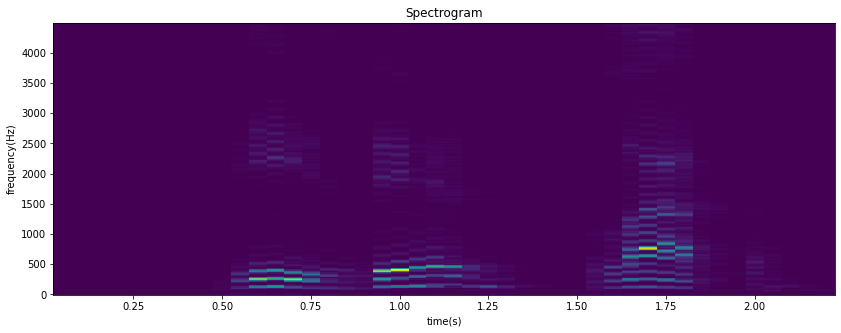

In [8]:
#Graphic Spectrogram 

plt.rcParams['figure.figsize'] = 14,5
plt.pcolormesh(t, f[:450], S1[:450][:])
plt.title("Spectrogram")
plt.xlabel('time(s)')
plt.ylabel('frequency(Hz)')

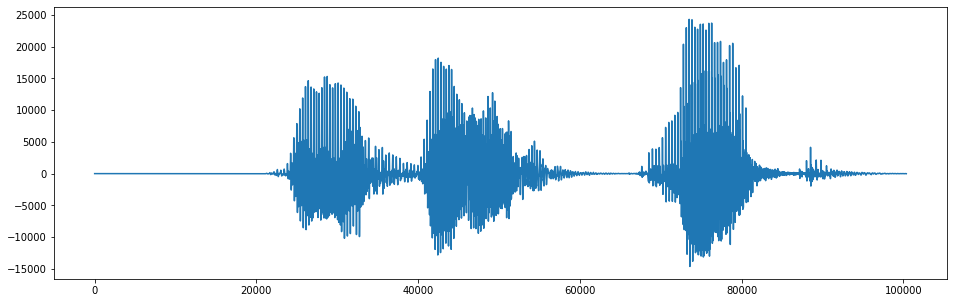

In [16]:
#Filtro ButterWord

wn = 1500/(fs/2)
b3,a3 = butter(4, wn)
#Apply the filter
audio1_filt = lfilter(b3,a3,audio1)

plt.plot(audio1_filt)

# Shown Audio after Filtered

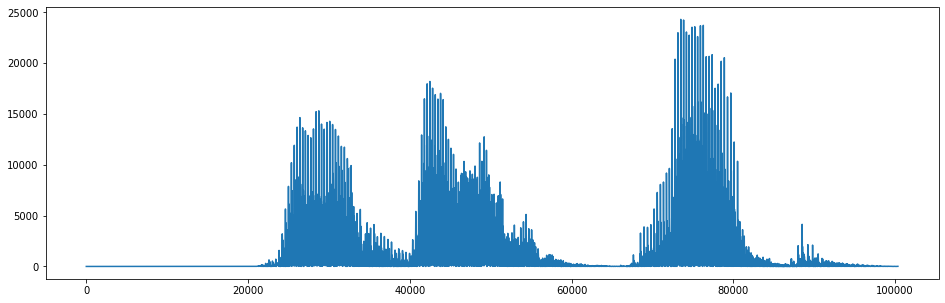

In [17]:
#Plot audio Filtered and only positive part

plt.rcParams['figure.figsize'] = 16,5
#plot(audio1,'r')
plt.plot(np.absolute(audio1_filt))

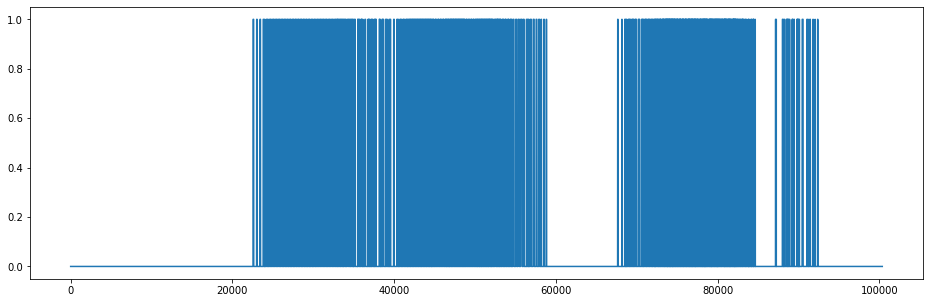

In [18]:
results = [1 if item > 350 else 0 for item in audio1_filt]
plt.plot(results)

# of chunks detected: 2
22550 58838
36288


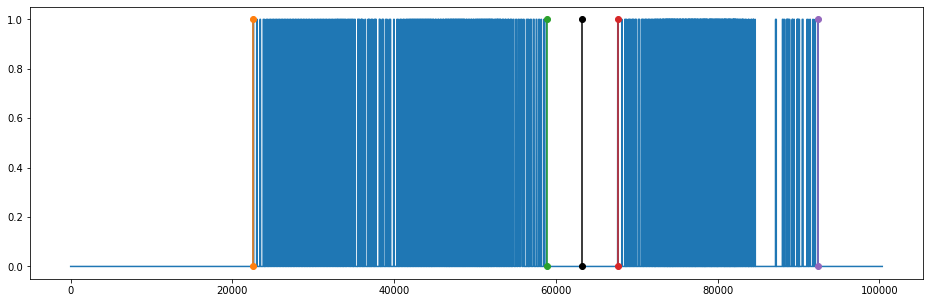

In [19]:
# Variables
x1 = x2 = 0
flag = False
chunks = []
coordinates = []
zeros_list = []
silence_len = 7500
min_len = 2000

plt.plot(results)
for i, result in enumerate(results):
    # First signal rise
    if(flag == False and result == 1 and x1 == 0):
        flag = True
        x1 = i
    # Check if fall is permanent
    if(flag == True):
        if(result == 0):
            zeros_list.append(result)
        else:
            zeros_list = []
    # Signal fall
    if(flag == True and len(zeros_list) >= silence_len and x2 == 0):
        flag = False
        x2 = i - len(zeros_list)
        # If data is valid, save it in list
        if(not x2-x1 <= min_len):
            chunks.append(results[x1:x2+1])
            coordinates.append([x1, x2])
            plt.plot([x1, x1], [0, 1], [x2, x2], [0, 1], marker='o')
        # Reset to initial state
        x1 = x2 = 0

print(f'# of chunks detected: {len(chunks)}')

pt1 = coordinates[0]
try:
    pt2 = coordinates[1]
    div_ptn = ((pt2[0] - pt1[1]) / 2) + pt1[1]
except:
    div_ptn = ((pt1[1] + pt1[0]) / 2)
    
# Draw dividing line
plt.plot([div_ptn, div_ptn], [0, 1], marker='o', color="black")
print(pt1[0], pt1[1])
print(pt1[1] - pt1[0])


# Split Audio

Split the audio in two

In [20]:
#Make segmentation point integer
div_ptn = round(div_ptn)

# Fix-sized segmentation (breaks a signal into non-overlapping segments)
signal = audio1 / (2**15)
signal_len = len(signal)
segment_size_t = 1 # segment size in seconds
segment_size = segment_size_t * fs  # segment size in samples

# Break signal into list of segments in a single-line Python code
segment1 = audio1[:div_ptn]
segment2 = audio1[div_ptn:]
segments = [segment1, segment2]

# Find out the number of Segments
n = len(segments)

# Acess the first chunk of the audio
samples = segments[0]
samples = np.array(samples)

# Process each chunk
# Save each segment in a seperate filename
for iS, s in enumerate(segments):
    write('audio/PD_data/'+filename+'_{0:d}.wav'.format(segment_size_t * iS, segment_size_t * (iS + 1)), fs, (s))


# Plot Power Spectrum

max value index:  [563]


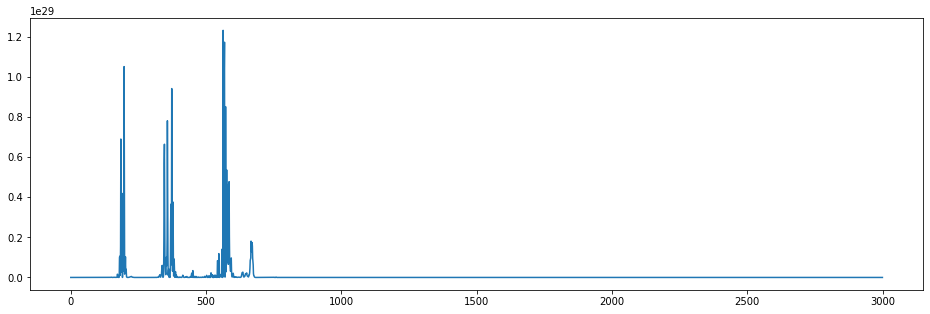

In [21]:
# Calculate Power Spectrum & Cepstrum
ceps, spec = real_cepstrum(samples, n=None)
N = samples.shape[0]

# Power Specturm
power_spec = np.abs(spec[:N//2])**2

# Index of the max power_spectrum
index = np.where(power_spec == np.max(power_spec))    

#Power Specturm
power_spec = np.abs(spec[:N//2])**2
plt.plot(power_spec[0:3000])

index = np.where(power_spec == np.max(power_spec))
print('max value index: ', index[0])

# Plot Cepstrum 

Cempstrum: 393


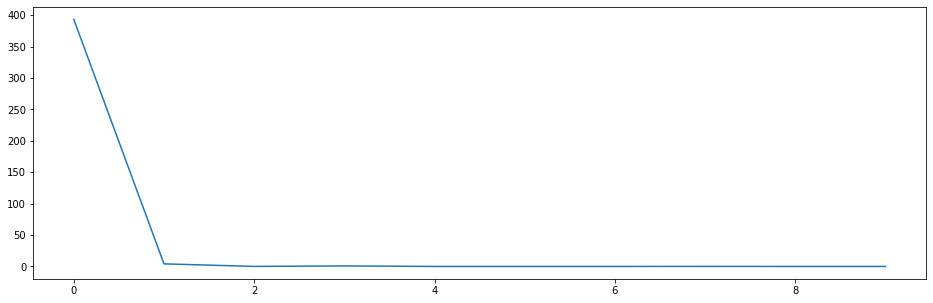

In [22]:
#Graphic the cepstrum

# Max value of the Cepstrum
abs_ceps = np.abs(ceps[:N//2])**2
plt.plot(abs_ceps[:10])
print(f'Cempstrum: {round(np.max(abs_ceps))}')

# Zero Crossing Rate

Zero Crossing Rate: 72


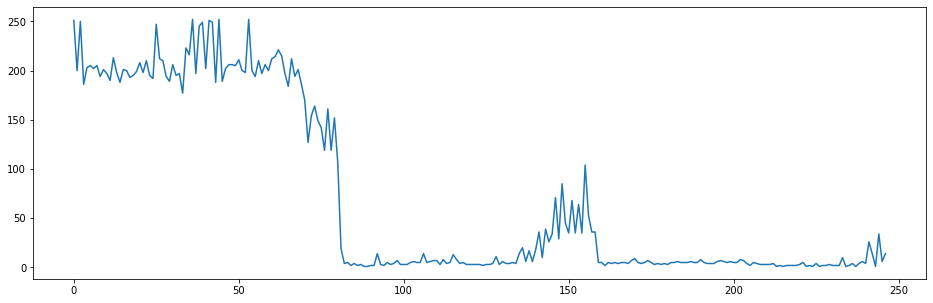

In [26]:
# Calculate Average of Zero Cross Rate

frameSize = 256
overlap = 0
zcr = ZCR(samples, frameSize, overlap)

plt.plot(zcr)
print(f'Zero Crossing Rate: {round(np.average(zcr))}')



# Loop code 

This is the code that analyse all audios in the dataset

In [ ]:
#History At = Success / Af = Fail
At = 0
Af = 0
Jt = 0
Jf = 0
Nt = 0
Nf = 0

#Parameters of Identification 

Pitch = [[350, 406],[407,500]] #A/(J&N)
Zcr_Avg = [[21,85],[11,20]] #(J/N)

#directory = 'C:/Users/lemos/PDS/TP/Pitch Detection/training/'
directory = 'C:/Users/Dasil/1. Processamento Digital do Sinal/Project/Pitch Detection/training/'


for file in os.listdir(directory):
   
    # Get audio file
    filename = os.path.join(directory, file)
    
    # Find person ID
    file = file.replace('.wav', '')
    file_parts = file.split('_')
    namep = file_parts[0]

    # Read file path
    fs, audio1 = read(filename)
    f,t,S1 = spectrogram(audio1, fs, window='flattop', nperseg=fs//10, noverlap=fs//20, scaling='spectrum', mode='magnitude')

    # Apply butterworth Filter
    wn = 1500/(fs/2)
    b3,a3 = butter(4, wn)
    audio1_filt = lfilter(b3,a3,audio1)

    #Audio threshold implementation
    results = [1 if item > 350 else 0 for item in audio1_filt] #350

    # Variables
    x1 = x2 = 0
    flag = False
    coordinates = []
    zeros_list = []
    silence_len = 7500 
    min_len = 2000 
    
    # Get audio chunks
    for i, result in enumerate(results):
        # First signal rise
        if(flag == False and result == 1 and x1 == 0):
            flag = True
            x1 = i
        # Check if fall is permanent
        if(flag == True):
            if(result == 0):
                zeros_list.append(result)
            else:
                zeros_list = []
        # Signal fall
        if(flag == True and len(zeros_list) >= silence_len and x2 == 0):
            flag = False
            x2 = i - len(zeros_list)
            # If data is valid, save it in list
            if(not x2-x1 <= min_len):
                coordinates.append([x1, x2])
            # Reset to initial state
            x1 = x2 = 0         
            
    pt1 = coordinates[0]
    try:
        pt2 = coordinates[1]
        div_ptn = ((pt2[0] - pt1[1]) / 2) + pt1[1]
    except:
        div_ptn = ((pt1[0] + pt1[1]) / 2)

    #Make segmentation point integer
    div_ptn = round(div_ptn)

    # Fix-sized segmentation (breaks a signal into non-overlapping segments)
    signal = audio1 / (2**15)
    signal_len = len(signal)
    segment_size_t = 1 # segment size in seconds
    segment_size = segment_size_t * fs  # segment size in samples

    # Break signal into list of segments in a single-line Python code
    segment1 = audio1[:div_ptn]
    segment2 = audio1[div_ptn:]
    segments = [segment1, segment2]

    # Find out the number of Segments
    n = len(segments)

    # Acess the first chunk of the audio
    samples = segments[0]
    samples = np.array(samples)
    
    # Calculate Power Spectrum & Cepstrum
    ceps, spec = real_cepstrum(samples, n=None)
    N = samples.shape[0]

    # Power Specturm
    power_spec = np.abs(spec[:N//2])**2

    # Index of the max power_spectrum
    index = np.where(power_spec == np.max(power_spec))

    # Max value of the Cepstrum
    abs_ceps = np.abs(ceps[:N//2])**2
    m_ceps = np.max(abs_ceps)
    
    # Classification tree of Identification
    if(Pitch[0][0] < m_ceps < Pitch[0][1]):
        # Case is Andre
        if(namep == 'A'):
            At += 1
        # Case is not andre
        else:
            if(namep == 'N'):
                Nf += 1
            else:
                Jf += 1
    #Case is Nuno or Joaquin
    elif (Pitch[1][0] < m_ceps < Pitch[1][1]):
        # Calculate Zero Crossing Rate
        frameSize = 256
        overlap = 0
        zcr = ZCR(samples, frameSize, overlap)
        #Case is joaquin
        if(Zcr_Avg[0][0] < round(np.average(zcr)) < Zcr_Avg[0][1]):
            if(namep == 'J'):
                Jt += 1
            else: 
                if(namep == 'N'):
                    Nf += 1
                else:
                    Af += 1
        #Case is Nuno
        elif((Zcr_Avg[1][0] < round(np.average(zcr)) < Zcr_Avg[1][1])):
            if(namep == 'N'):
                Nt += 1
            else: 
                if(namep == 'J'):
                    Jf += 1
                else:
                    Af += 1
        else:
            if(namep == 'J'):
                Jf += 1
            else:
                Nf += 1
    #Failed to recognise
    else:
        if(namep == 'N'):
            Nf += 1
        elif(namep == 'A'):
            Af += 1
        else: 
            Jf += 1
            
# Intialise data of lists.
data = {'Student':['André', 'Joaquin', 'Nuno'],
        'True':[At, Jt, Nt],
        'False':[Af, Jf, Nf],
        'Success (%)':[(At / (At+Af)) * 100, (Jt / (Jt+Jf)) * 100, (Nt / (Nt+Nf)) * 100]}
 
# Create DataFrame
df = pd.DataFrame(data)
df.round(decimals=2) 
# Print the output.
df   

C:\Users\Dasil\AppData\Local\Temp/ipykernel_29508/2284208719.py:29: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, audio1 = read(filename)
